Jenna Ruzekowicz (jenna.ruzekowicz@nrel.gov) and Caleb Phillips (caleb.phillips@nrel.gov)

The purpose of this notebook is to read in two sets of data over the same time period for comparison:
1) WTK-LED data
2) Either: 
    a) power output and/or wind speed data from turbine(s) 
    b) wind speed measurements from met tower(s)

Data sets are matched on location and time stamp.

A combined and labeled dataframe will be exported to a csv file in the "01Data" folder. The naming convention for the csv file will be as follows: source_lat_lon_startdate_enddate.csv
where source is either "bergey", "oneenergy"...

Notes: 
Might need to install Rex if it isn't installed already:
conda install nrel-rex --channel=nrel

More about rex: https://github.com/NREL/rex
2018 5-min monthly h5 (the file you referenced on the 21st):
/campaign/tap/CONUS/wtk/5min/2018/{month}/conus_2018-{month}.h5
 
2018 5-min yearly h5 slices:
/shared-projects/wtk-led/CONUS/wtk/2018/yearly_h5/conus_2018_{height}m.h5
 
2019 60-min yearly h5:
/campaign/tap/CONUS/wtk/60min/2019/conus_2019.h5

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
from rex.resource_extraction import MultiYearWindX
from dw_tap.data_fetching import get_data_wtk_led_on_eagle # does not seem to exist in the current package version
from tqdm import tqdm
import plotly.express as px
from scipy.interpolate import interp1d
import plotly.graph_objects as go

### Read in per-turbine data, merge and resample to 5 minutes

In [2]:
index = pd.read_csv("01 Bergey Turbine Data/bergey_sites.csv")
index.head()

,APRS ID,Public Site Name,Internal Site Name,State,Latitude,Longitude,Hub Height (m),Turbine,Periods with Consistent Generation Data,Met Tower,Met Tower Latitude,Met Tower Longitude,Measurement Height (m)
0,t007,Fremont,Fremont,MN,43.918622,-91.899498,41,Bergey Excel 10,2012/01 - 2013/12 (outage starting mid-2013/11...,NaN,NaN,NaN,NaN
1,t024,Washoe,Thomas Danzinger,NV,39.331088,-119.820234,30,Bergey Excel 10,2011/01 - 2022/12,NaN,NaN,NaN,NaN
2,t028,Towamensing,Derr,PA,40.851353,-75.598395,30,Bergey Excel 10,2011/01 - 2022/12,NaN,NaN,NaN,NaN
3,t034,Lycoming,Dan Poor,NY,43.524158,-76.372290,31,Bergey Excel 10,"2013/01 - 2017/12, 2019/01 - 2021/12",Oswego,43.464,-76.511,15.0
4,t041,Rockford,Fossil Park,IA,43.047418,-92.981674,37,Bergey Excel 10,"2013/01 - 2013/12, 2015/01 - 2022/12",NaN,NaN,NaN,NaN


In [3]:
# Guessing what system state means...
# 9 = online, generating
# 7,5,6,4,14,12,8,11 = curtailed or offline

In [4]:
dfs = []
for i in tqdm(index["APRS ID"]):
    dc = pd.read_csv("01 Bergey Turbine Data/%s.txt" % i,usecols=["packet_date","system_state","output_power"])
    # FIXME: keeping only data where system state == 9, is this okay?
    dc = dc[dc.system_state == 9]
    # FIXME: I'm not sure what timezone packet_date is in or whether we need this line
    dc["packet_date"] = pd.to_datetime(dc["packet_date"]).dt.tz_localize('UTC')
    # Resample to 5 minutes to align with wind toolkit data
    dc = dc.resample("5T",on="packet_date").agg({ 'output_power': ['mean',list] }).reset_index()
    # Simplify column names
    dc.columns = ["packet_date","output_power_mean","output_power_list"]
    dc["tid"] = i
    dfs.append(dc)

  0%|                                                    | 0/19 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '01 Bergey Turbine Data/t007.txt'

In [12]:
bergey_data = pd.concat(dfs)
#bergey_data.head()

,packet_date,output_power_mean,output_power_list,tid
0,2018-06-30 00:00:00+00:00,1841.533333,"[4549, 3890, 1974, 1506, 1017, 1521, 1772, 102...",t007
1,2018-06-30 00:05:00+00:00,1855.800000,"[957, 1124, 2295, 3253, 3073, 2366, 1592, 2020...",t007
2,2018-06-30 00:10:00+00:00,1355.800000,"[1095, 286, 400, 271, 462, 275, 291, 153, 2397...",t007
3,2018-06-30 00:15:00+00:00,1495.933333,"[966, 856, 882, 535, 539, 3131, 1868, 1318, 17...",t007
4,2018-06-30 00:20:00+00:00,1740.300000,"[2543, 2119, 880, 1731, 2749, 1717, 921, 818, ...",t007


### Use Power-curve to try to reverse out windspeed

In [13]:
powercurve = pd.read_csv("../../bergey/bergey_excel10_powercurve.csv")
powercurve.columns = ["windspeed","power_kwh"]
powercurve_intrp = interp1d(powercurve["windspeed"], powercurve["power_kwh"], kind='cubic')
powercurve

,windspeed,power_kwh
0,0.0,-0.012
1,0.5,-0.012
2,1.0,-0.012
3,1.5,-0.011
4,2.0,0.000
5,2.5,0.039
6,3.0,0.102
7,3.5,0.229
8,4.0,0.399
9,4.5,0.596


In [21]:
powercurve_intrp(powercurve["windspeed"])

array([-1.2000e-02, -1.2000e-02, -1.2000e-02, -1.1000e-02,  0.0000e+00,
        3.9000e-02,  1.0200e-01,  2.2900e-01,  3.9900e-01,  5.9600e-01,
        8.4800e-01,  1.1510e+00,  1.5100e+00,  1.9380e+00,  2.4030e+00,
        2.9490e+00,  3.6020e+00,  4.3060e+00,  5.0710e+00,  5.9600e+00,
        6.8560e+00,  7.8490e+00,  8.8630e+00,  9.9280e+00,  1.0885e+01,
        1.1619e+01,  1.2019e+01,  1.2276e+01,  1.2395e+01,  1.2449e+01,
        1.2495e+01,  1.2508e+01,  1.2546e+01,  1.2555e+01,  1.2503e+01,
        1.2528e+01,  1.2442e+01,  1.2396e+01,  1.2208e+01,  1.1878e+01,
        1.1989e+01,  1.1495e+01])

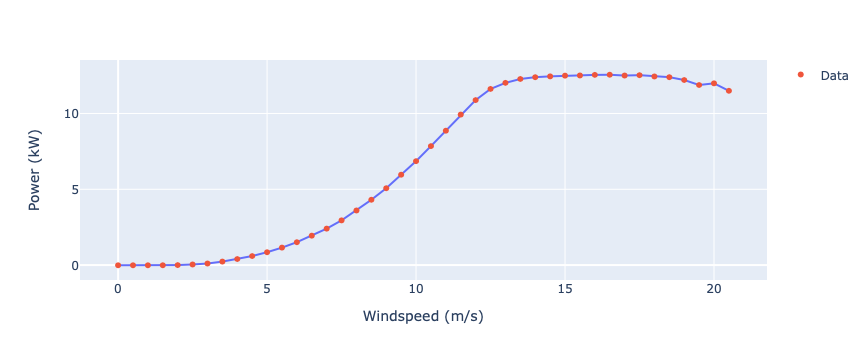

In [24]:
fig = px.line(y=powercurve_intrp(powercurve["windspeed"]), x=powercurve["windspeed"],
              labels={"x":"Windspeed (m/s)","y":"Power (kW)"})
fig.add_trace(go.Scatter(y=powercurve["power_kwh"], x=powercurve["windspeed"],
                    mode='markers',
                    name='Data'))
fig.show()
# Fixme: currently we aren't doing anything with the un-invertable portions of this curve

Inspect data to make sure it seems compatible

In [25]:
flat_power = [item for sublist in bergey_data["output_power_list"] for item in sublist]
flat_power = pd.DataFrame(flat_power)
flat_power.columns = ["output_power"]

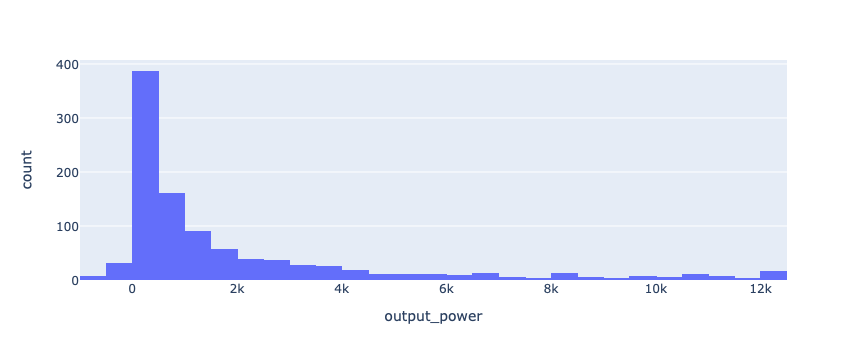

In [26]:
fig = px.histogram(flat_power.sample(n=1000, random_state=1),x="output_power")
fig.show()

In [27]:
#fig = px.histogram(bergey_data,x="output_power_mean",facet_col="tid",facet_col_wrap=6)
#fig.show()

In [30]:
# Apply to full turbine data - note divide by 1000 to convert Watts to kW

# Note we are not specifically dealing with cases where power is beyond the power curve or below the minimum

# Sampling a hundred points from the interpolated function
# allows us to invert with an approximate accuracy of 12/100 or 0.1
ws2 = np.linspace(0, 12, num=100)
pc2 = powercurve_intrp(ws2)
bergey_data["windspeed_mps"] = (bergey_data["output_power_mean"]/1000).map(lambda x: ws2[np.abs(pc2 - x).argmin()] )
bergey_data.head()

,packet_date,output_power_mean,output_power_list,tid,windspeed_mps
0,2018-06-30 00:00:00+00:00,1841.533333,"[4549, 3890, 1974, 1506, 1017, 1521, 1772, 102...",t007,6.424242
1,2018-06-30 00:05:00+00:00,1855.800000,"[957, 1124, 2295, 3253, 3073, 2366, 1592, 2020...",t007,6.424242
2,2018-06-30 00:10:00+00:00,1355.800000,"[1095, 286, 400, 271, 462, 275, 291, 153, 2397...",t007,5.818182
3,2018-06-30 00:15:00+00:00,1495.933333,"[966, 856, 882, 535, 539, 3131, 1868, 1318, 17...",t007,5.939394
4,2018-06-30 00:20:00+00:00,1740.300000,"[2543, 2119, 880, 1731, 2749, 1717, 921, 818, ...",t007,6.303030


In [31]:
# Save out compressed CSV as a checkpoint
bergey_data[["tid","packet_date","output_power_mean","windspeed_mps"]].\
    to_csv("01 Bergey Turbine Data/prepared_and_combined.csv.bz2",index=False)

### Fetch Corresponding Wind Toolkit Data and Merge

Todo